## Download Mosaics

Use of the gdal PLMosaic driver requires specification of the planet api key. This can either be specified in the command-line options, or gdal will try to pull this from the environmental variable `PL_API_KEY`. This notebook assumes that the environmental variable `PL_API_KEY` is set. See the [gdal PLMosaic driver](https://www.gdal.org/frmt_plmosaic.html) for more information.

In [1]:
import os
import subprocess
import tempfile

from planet import api
from planet.api import downloader, filters

In [2]:
# uncomment to see what mosaics are available and to make sure the PLMosaic driver is working
# !gdalinfo "PLMosaic:"

In [3]:
# get mosaic names for July 2017 to March 2018
mosaic_dates = [('2017', '{0:02d}'.format(m)) for m in range(7, 13)] + \
               [('2018', '{0:02d}'.format(m)) for m in range(1, 4)]
mosaic_names = ['global_monthly_{}_{}_mosaic'.format(yr, mo)
                for (yr, mo) in mosaic_dates]

def get_mosaic_filename(mosaic_name):
    return os.path.join('data', mosaic_name + '.tif')

for name in mosaic_names:
    print('{} -> {}'.format(name, get_mosaic_filename(name)))

global_monthly_2017_07_mosaic -> data/global_monthly_2017_07_mosaic.tif
global_monthly_2017_08_mosaic -> data/global_monthly_2017_08_mosaic.tif
global_monthly_2017_09_mosaic -> data/global_monthly_2017_09_mosaic.tif
global_monthly_2017_10_mosaic -> data/global_monthly_2017_10_mosaic.tif
global_monthly_2017_11_mosaic -> data/global_monthly_2017_11_mosaic.tif
global_monthly_2017_12_mosaic -> data/global_monthly_2017_12_mosaic.tif
global_monthly_2018_01_mosaic -> data/global_monthly_2018_01_mosaic.tif
global_monthly_2018_02_mosaic -> data/global_monthly_2018_02_mosaic.tif
global_monthly_2018_03_mosaic -> data/global_monthly_2018_03_mosaic.tif


In [4]:
aoi_filename = 'pre-data/aoi.geojson'

In [5]:
def _gdalwarp(input_filename, output_filename, options):
    commands = ['gdalwarp'] + options + \
               ['-overwrite',
                input_filename,
                output_filename]
    print(' '.join(commands))
    subprocess.check_call(commands)

# lossless compression of an image
def _compress(input_filename, output_filename):
    commands = ['gdal_translate',
                '-co', 'compress=LZW',
                '-co', 'predictor=2',
                input_filename,
                output_filename]
    print(' '.join(commands))
    subprocess.check_call(commands)

def download_mosaic(mosaic_name,
             output_filename,
             crop_filename,
             overwrite=False,
             compress=True):
    # typically gdalwarp would require `-oo API_KEY={PL_API_KEY}`
    # but if the environmental variable PL_API_KEY is set, gdal will use that
    options = ['-cutline', crop_filename, '-crop_to_cutline',
               '-oo', 'use_tiles=YES']
    
    # use PLMosaic driver
    input_name = 'PLMosaic:mosaic={}'.format(mosaic_name)
    
    # check to see if output file exists, if it does, do not warp
    if os.path.isfile(output_filename) and not overwrite:
        print('{} already exists. Aborting download of {}.'.format(output_filename, mosaic_name))
    elif compress:
        with tempfile.NamedTemporaryFile(suffix='.vrt') as vrt_file:
            options += ['-of', 'vrt']
            _gdalwarp(input_name, vrt_file.name, options)
            _compress(vrt_file.name, output_filename)
    else:
        _gdalwarp(input_name, output_filename, options)

for name in mosaic_names:
    download_mosaic(name, get_mosaic_filename(name), aoi_filename)

data/global_monthly_2017_07_mosaic.tif already exists. Aborting download of global_monthly_2017_07_mosaic.
data/global_monthly_2017_08_mosaic.tif already exists. Aborting download of global_monthly_2017_08_mosaic.
data/global_monthly_2017_09_mosaic.tif already exists. Aborting download of global_monthly_2017_09_mosaic.
data/global_monthly_2017_10_mosaic.tif already exists. Aborting download of global_monthly_2017_10_mosaic.
data/global_monthly_2017_11_mosaic.tif already exists. Aborting download of global_monthly_2017_11_mosaic.
data/global_monthly_2017_12_mosaic.tif already exists. Aborting download of global_monthly_2017_12_mosaic.
data/global_monthly_2018_01_mosaic.tif already exists. Aborting download of global_monthly_2018_01_mosaic.
data/global_monthly_2018_02_mosaic.tif already exists. Aborting download of global_monthly_2018_02_mosaic.
data/global_monthly_2018_03_mosaic.tif already exists. Aborting download of global_monthly_2018_03_mosaic.


## Classify Mosaics into Forest and Non-Forest

Although we have already performed classification of a 4-band Orthotile into forest and non-forest in [drc_roads_classification](drc_roads_classification.ipnb), the format of the data is different in mosaics, so we need to re-create our training dataset. We will use the same label images that were created as a part of that notebook. We will, however, pull a lot of code from that notebook.

In [6]:
import os

import numpy as np
import rasterio

#### Create Label Masks

In [7]:
# Import functionality from local notebooks
from ipynb.fs.defs.drc_roads_classification import get_label_mask, get_unmasked_count

# def get_label_mask(image_filename):
#     with rasterio.open(image_filename, 'r') as src:
#         band = src.read(1)
#         label_data = band == 255 # valid data in white regions
#         label_mask = ~label_data # mask True (masked) for not valid data
#     return label_mask

# def get_unmasked_count(mask):
#     return np.size(mask) - np.count_nonzero(mask)

In [8]:
forest_img = os.path.join('pre-data', 'forestroad_forest.tif')
road_img = os.path.join('pre-data', 'forestroad_road.tif')

In [9]:
forest_mask = get_label_mask(forest_img)
print(get_unmasked_count(forest_mask))

road_mask = get_label_mask(road_img)
print(get_unmasked_count(road_mask))

forest_mask.shape

/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:240: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s = DatasetReader(fp, driver=driver, **kwargs)


6652509
17219


(3333, 6008)

#### Match Images

To use the label images to create a training dataset, we must first match the images so that the pixel dimensions and locations line up. To do this, we warp the mosaic image to match the label image coordinate reference system, bounds, and pixel dimensions.

In [10]:
image_file = get_mosaic_filename(mosaic_names[0])
image_file

'data/global_monthly_2017_07_mosaic.tif'

In [11]:
label_image = 'pre-data/roads.tif'

In [12]:
# !gdalinfo $image_file

In [13]:
# get label image crs, bounds, and pixel dimensions
with rasterio.open(label_image, 'r') as ref:
    dst_crs = ref.crs['init']
    (xmin, ymin, xmax, ymax) = ref.bounds
    width = ref.width
    height = ref.height

print(dst_crs)
print((xmin, ymin, xmax, ymax))
print((width, height))

epsg:32635
(324669.121082206, 113387.27147534769, 343445.6303321145, 123803.11319740933)
(6008, 3333)


In [14]:
training_file = os.path.join('data', 'mosaic_training.tif')

In [15]:
# use gdalwarp to warp mosaic image to match label image
!gdalwarp -t_srs $dst_crs \
    -te $xmin $ymin $xmax $ymax \
    -ts $width $height \
    -overwrite $image_file $training_file

Using band 4 of source image as alpha.
Creating output file that is 6008P x 3333L.
Processing data/global_monthly_2017_07_mosaic.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


#### Create Training Datasets

Now that the images match, we create the training datasets from the labels and the mosaic bands.

In [16]:
from functools import reduce

from skimage import feature, filters
from sklearn.ensemble import RandomForestClassifier

In [17]:
# Import functionality from local notebooks
from ipynb.fs.defs.drc_roads_classification import \
    load_4band, get_feature_bands, combine_masks, num_valid, perc_masked, bands_to_X, \
    make_same_size_samples

# def load_4band(filename):
#     with rasterio.open(filename, 'r') as src:
#         # orthotile band ordering: blue, green, red, nir
#         b, g, r, n = src.read() 

#         mask = b == 0 # 0 is NoData

#     return [np.ma.array(band, mask=mask) for band in [b, g, r, n]]

# def get_texture_features(bands):
#     green_band = bands[1]
#     edges1 = feature.canny(green_band, low_threshold=0.0, high_threshold=0.01, sigma=2)
#     blurred = filters.gaussian(edges1, sigma=2)
#     blurred2 = filters.gaussian(edges1, sigma=6)
#     return [np.ma.array(texture_band, mask=green_band.mask)
#             for texture_band in (blurred, blurred2)]

# def get_feature_bands(image_file):
#     spectral_bands = load_4band(image_file)
#     texture_bands = get_texture_features(spectral_bands)
#     return spectral_bands + texture_bands

# def perc_masked(mask):
#     return 100*(np.count_nonzero(mask))/mask.size

# def num_valid(mask):
#     return (mask.size - np.count_nonzero(mask))

# def combine_masks(feature_bands):
#     masks = [b.mask for b in feature_bands]
#     total_mask = reduce(np.logical_or, masks)
#     print('{} valid pixels ({}% masked)'.format(num_valid(total_mask),
#                                                 round(perc_masked(total_mask), 2)))
#     return total_mask

# def valid_pixels(band, mask):
#     masked_band = np.ma.array(band, mask=mask)
#     return masked_band.compressed()

# def bands_to_X(feature_bands, mask):
#     # X shape: (num_pixels, num_bands)
#     all_valid_pixels = [valid_pixels(b, mask) for b in feature_bands]
#     X = np.swapaxes(np.stack(all_valid_pixels), 0, 1)
#     return X

# def sample_pixels(pixels, sample_size):
#     if pixels.shape[0] > sample_size:
#         pixel_sample = pixels.copy()
#         np.random.shuffle(pixel_sample)
#         pixel_sample = pixel_sample[:sample_size]
#     else:
#         pixel_sample = pixels
#     return pixel_sample
    
# def make_same_size_samples(list_of_X, size_percent=100):
#     # X: array of dim (num_pixels, num_classified_bands)
#     sample_len = min([p.shape[0] for p in list_of_X])

#     # only return size_percent number of pixels in the sample
#     if size_percent < 100 and size_percent > 0:
#         sample_len = round(sample_len * size_percent/100.0)
    
#     return [sample_pixels(p, sample_len) for p in list_of_X]

In [18]:
feature_bands = get_feature_bands(training_file)
print(feature_bands[0].shape)

total_mask = combine_masks(feature_bands)
print(total_mask.shape)

(3333, 6008)
20001980 valid pixels (0.11% masked)
(3333, 6008)


In [19]:
# combine the label masks with the valid data mask and then create X dataset for each label
total_forest_mask = np.logical_or(total_mask, forest_mask)
print('{} valid pixels ({}% masked)'.format(num_valid(total_forest_mask),
                                            round(perc_masked(total_forest_mask), 2)))
X_forest = bands_to_X(feature_bands, total_forest_mask)

total_road_mask = np.logical_or(total_mask, road_mask)
print('{} valid pixels ({}% masked)'.format(num_valid(total_road_mask),
                                            round(perc_masked(total_road_mask), 2)))
X_road = bands_to_X(feature_bands, total_road_mask)

6652509 valid pixels (66.78% masked)
17219 valid pixels (99.91% masked)


In [20]:
[X_forest_sample, X_road_sample] = \
    make_same_size_samples([X_forest, X_road], size_percent=100)

print(X_forest_sample.shape)
print(X_road_sample.shape)

(17219, 6)
(17219, 6)


In [21]:
forest_label_value = 0
road_label_value = 1
X_training = np.concatenate((X_forest_sample, X_road_sample), axis=0)
y_training = np.array(X_forest_sample.shape[0] * [forest_label_value] + \
                      X_road_sample.shape[0] * [road_label_value])
    
print(X_training.shape)
print(y_training.shape)

(34438, 6)
(34438,)


### Run classification

In [22]:
from utils import Timer

In [23]:
from ipynb.fs.defs.drc_roads_classification import classify_forest, y_to_band, classified_band_to_rgb

# def classify_forest(image_file, X_training, y_training):
#     clf = RandomForestClassifier()
    
#     with Timer():
#         clf.fit(X_training, y_training)
    
#     # for random forest classification, no normalization of the features is required
#     feature_bands = get_feature_bands(image_file)
#     total_mask = combine_masks(feature_bands)
#     X_rf = bands_to_X(feature_bands, total_mask)
    
#     with Timer():
#         y_pred_rf = clf.predict(X_rf)

#     y_band_rf = y_to_band(y_pred_rf, total_mask)
#     return y_band_rf

# def y_to_band(y, mask):
#     band = np.ma.array(np.zeros(mask.shape), mask=mask)
#     band[~band.mask] = y
#     return band

In [24]:
# load local visual module
import visual

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
8622399 valid pixels (0.0% masked)
5 seconds
10 seconds


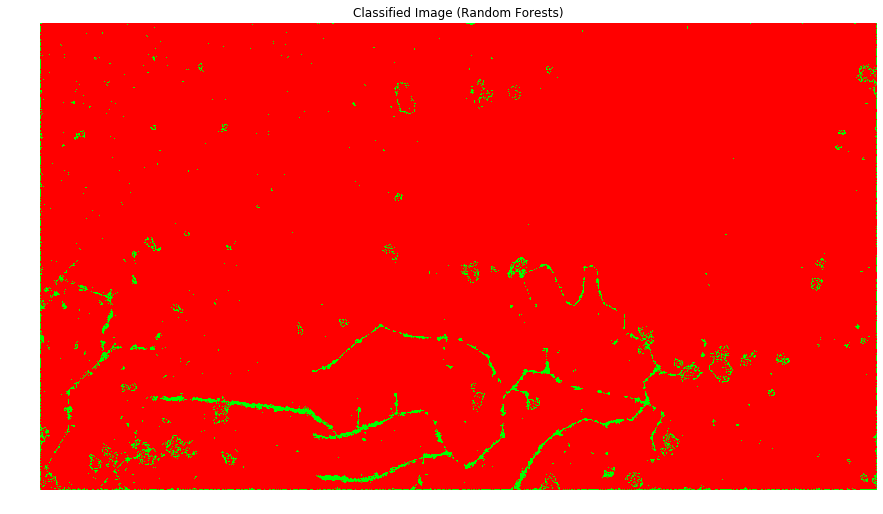

In [25]:
with Timer():
    y_band_rf = classify_forest(image_file, X_training, y_training)
    
visual.plot_image(classified_band_to_rgb(y_band_rf),
                  title='Classified Image (Random Forests)',
                  figsize=(15, 15))

### Run forest classification on all mosaics

In [26]:
# for image_file in mosaic_output_names:
#     y_band_rf = classify_forest(image_file, X_training, y_training)

In [27]:
# mosaic_names, mosaic_output_names

In [28]:
classified_bands_file = os.path.join('data', 'classified_mosaic_bands.npz')

def save_to_cache(classified_bands, mosaic_names):
    save_bands = dict((s, classified_bands[s])
                      for s in mosaic_names)
    # masked arrays are saved as just arrays, so save mask for later
    save_bands.update(dict((s+'_msk', classified_bands[s].mask)
                           for s in mosaic_names))
    np.savez_compressed(classified_bands_file, **save_bands)  

def load_from_cache():
    classified_bands = np.load(classified_bands_file)
    scene_ids = [k for k in classified_bands.keys() if not k.endswith('_msk')]
#     for s in scene_ids:
#         print(classified_bands[s].shape)
#         print(classified_bands[s+'_msk'].shape)

    # reform masked array from saved array and saved mask
    classified_bands = dict((s, np.ma.array(classified_bands[s], mask=classified_bands[s+'_msk']))
                            for s in scene_ids)
    return classified_bands

In [29]:
use_cache = True

if use_cache and os.path.isfile(classified_bands_file):
    print('using cached classified bands')
    classified_bands = load_from_cache()
else:
    with Timer():
        def classify(mosaic_name):
            img = get_mosaic_filename(mosaic_name)
            # we only have two values, 0 and 1. Convert to uint8 for memory
            band = (classify_forest(img, X_training, y_training)).astype(np.uint8)
            return band

        classified_bands = dict((s, classify(s)) for s in mosaic_names)
    
    # save to cache
    save_to_cache(classified_bands, mosaic_names)

using cached classified bands


In [30]:
# load local visual module

import importlib
import visual
importlib.reload(visual)

<module 'visual' from '/home/jovyan/work/jupyter-notebooks/forest-monitoring/visual.py'>

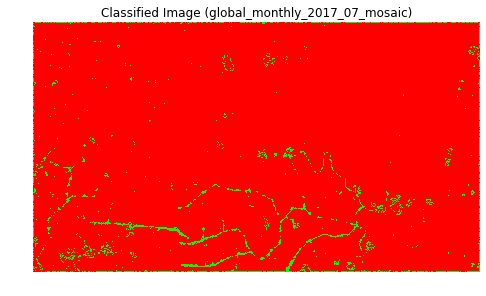

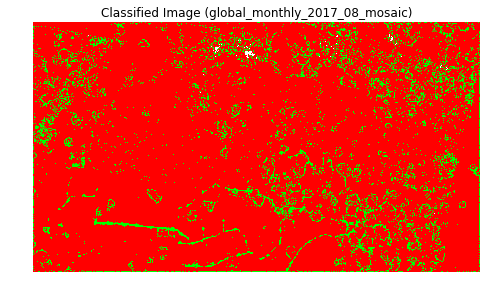

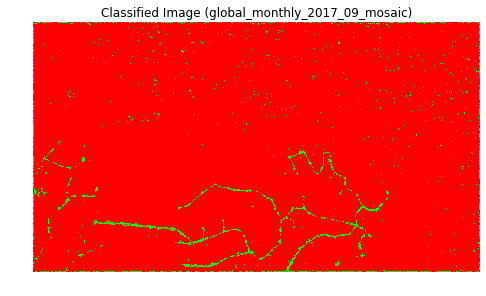

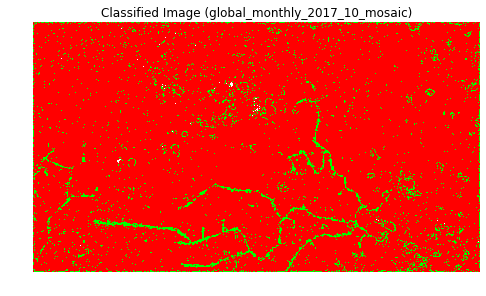

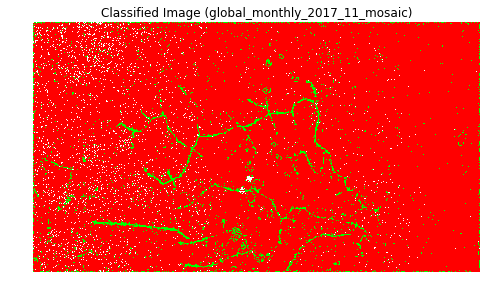

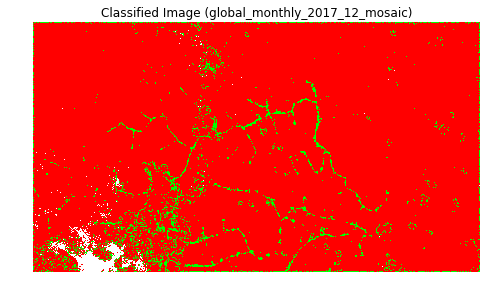

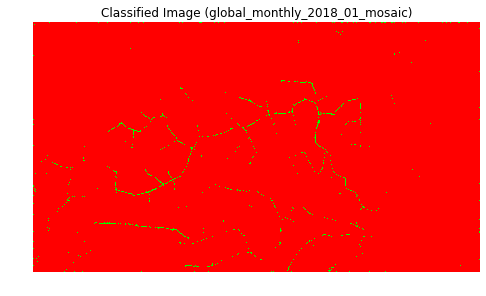

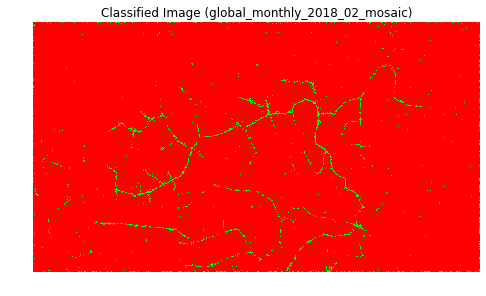

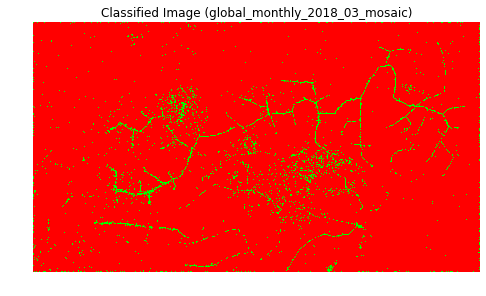

In [31]:
# Decimate classified arrays for memory conservation
def decimate(arry, num=8):
    return arry[::num, ::num].copy()

do_visualize = True # set to True to view images
if do_visualize:
    for mosaic_name, classified_band in classified_bands.items():
        visual.plot_image(classified_band_to_rgb(decimate(classified_band)),
                          title='Classified Image ({})'.format(mosaic_name),
                          figsize=(8, 8))

These classified mosaics look a lot better than the classified Orthotile strips. This is very positive for change classification!

## Identify Change

### Create Label Masks

The label images were created in drc_roads_temporal_analysis.ipynb.

They are not in the same crs as the mosaic image. they need to be warped to match the mosaic images.

1. Project band to label crs
2. Crop band to label bounds
3. Band to label dimensions

In [68]:
# labeled change images, not georeferenced
change_img_orig = os.path.join('pre-data', 'difference_change.tif')
nochange_img_orig = os.path.join('pre-data', 'difference_nochange.tif')

# georeferenced source image
src_img = os.path.join('pre-data', 'difference.tif')

In [69]:
# destination georeferened label images
change_img_geo = os.path.join('data', 'difference_change.tif')
nochange_img_geo = os.path.join('data', 'difference_nochange.tif')

In [75]:
# get source crs
with rasterio.open(src_img, 'r') as src:
    src_crs = src.crs
    src_transform = src.transform

for (label_img, geo_img) in ((change_img_orig, change_img_geo), 
                             (nochange_img_orig, nochange_img_geo)):
    with rasterio.open(label_img, 'r') as src:
        profile = {
            'width': src.width,
            'height': src.height,
            'driver': 'GTiff',
            'count': src.count,
            'compress': 'lzw',
            'dtype': rasterio.uint8,
            'crs': src_crs,
            'transform': src_transform
        }
        
        with rasterio.open(geo_img, 'w', **profile) as dst:
            dst.write(src.read())

/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:240: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s = DatasetReader(fp, driver=driver, **kwargs)


In [76]:
# !gdalinfo $change_img_geo

In [78]:
# get dest crs, bounds, and shape from mosaic image
image_file = get_mosaic_filename(mosaic_names[0])

with rasterio.open(image_file, 'r') as ref:
    dst_crs = ref.crs['init']
    (xmin, ymin, xmax, ymax) = ref.bounds
    width = ref.width
    height = ref.height

print(dst_crs)
print((xmin, ymin, xmax, ymax))
print((width, height))

epsg:3857
(2830219.5489774016, 114168.43998953675, 2848995.3656599834, 124647.6787126414)
(3930, 2194)


In [86]:
# destination matched images
change_img = os.path.join('data', 'mosaic_difference_change.tif')
nochange_img = os.path.join('data', 'mosaic_difference_nochange.tif')

In [65]:
# !gdalinfo $change_img_orig

In [84]:
# resample and resize to match mosaic
!gdalwarp -t_srs $dst_crs \
    -te $xmin $ymin $xmax $ymax \
    -ts $width $height \
    -overwrite $change_img_geo $change_img

!gdalwarp -t_srs $dst_crs \
    -te $xmin $ymin $xmax $ymax \
    -ts $width $height \
    -overwrite $nochange_img_geo $nochange_img

Creating output file that is 3930P x 2194L.
Processing data/difference_change.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 3930P x 2194L.
Processing data/difference_nochange.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [85]:
change_mask = get_label_mask(change_img)
print(get_unmasked_count(change_mask))
nochange_mask = get_label_mask(nochange_img)
print(get_unmasked_count(nochange_mask))

97356
3347608


### Match Images

### Get Features from Labels